Parallelization :

Running multiple LLM calls or tools at the same time instead of one after another.

In LangGraph:

Multiple nodes execute concurrently
Final node joins their outputs

When SHOULD you use parallelization:
Who is the PM of India and GDP of India?

Parallel:
Wikipedia → PM
WorldBank API → GDP

Summarize this repo and find security issues”

Parallel:
Code summarizer agent
Security scanner agent
Dependency analyzer agent
All run together → aggregator node combines result.

RAG over multiple collections

Use case:
Enterprise chatbot

Parallel queries to:
Policies DB
Engineering docs
Support tickets
Slack history

Then:
merge
rerank
answer

Use case:

“Generate answer and verify it”

Parallel:

Generator LLM
Fact-checker LLM
Safety checker LLM

Only return answer if all pass.

Used in:
Finance
Healthcare
Legal AI



When you should use parallelization:
For independent Tasks

When you should NOT use parallelization:
When steps depend on each other eg: Find company → get revenue → calculate growth




In [6]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing_extensions import TypedDict,Annotated
from IPython.display import display,Image


In [7]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT']='Agent_React'


In [8]:
# # Initialize chat model
from langchain_groq import ChatGroq

llm =ChatGroq(model="llama-3.1-8b-instant")

In [9]:
class State(TypedDict):
    topic:str
    characters:str
    settings:str
    premises:str
    story_intro:str

In [12]:
def generate_characters(state:State):
    """
    Generate character descriptions
    """
    msg = llm.invoke(f"Create two characters names and brief traits for a story about {state['topic']}")
    return {"characters":msg.content}

def generate_Settings(state:State):
    """
    Generate a Story Setting
    """
    msg =llm.invoke(f"Describe a vivid setting for a story about{state['topic']}")
    return {"settings":msg.content}

def generate_premises(state:State):
    """
    Generate a story premise"""

    msg =llm.invoke(f"write a one sentence plot premise for a story about {state['topic']}")
    return {"premises":msg.content}

def combine_elements(state:State):
    """
    Combine Characters ,settings and premises to create a story intro
    """
    msg =llm.invoke(
    f"write a short story introduction using these three elements:\n"
    f"characters :{state['characters']}\n"
    f"settings   :{state['settings']}\n"
    f"premises   :{state['premises']} "
    )
    return {"story_intro":msg.content}


    

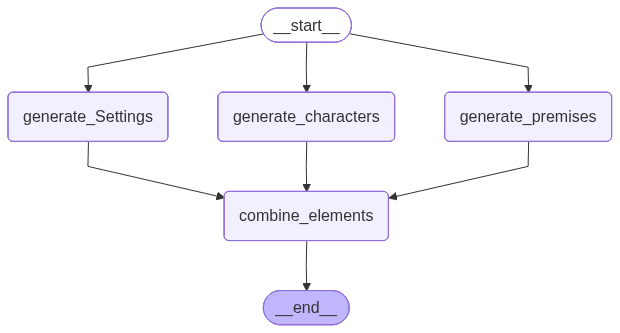

In [13]:
graph =StateGraph(State)

graph.add_node('generate_characters',generate_characters)
graph.add_node('generate_Settings',generate_Settings)
graph.add_node('generate_premises',generate_premises)
graph.add_node('combine_elements',combine_elements)

graph.add_edge(START,'generate_characters')
graph.add_edge(START,'generate_Settings')
graph.add_edge(START,'generate_premises')
graph.add_edge('generate_characters','combine_elements')
graph.add_edge('generate_Settings','combine_elements')
graph.add_edge('generate_premises','combine_elements')
graph.add_edge('combine_elements',END)

graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))



In [14]:
state={"topic":"time travel"}

result =graph_builder.invoke(state)
result

{'topic': 'time travel',
 'characters': 'Here are two potential characters for a time travel story:\n\n**1. Character: Alexandra "Lexi" Thompson**\n\n- Age: 25\n- Occupation: Physicist\n- Personality: Lexi is a brilliant and resourceful individual with a passion for solving complex problems. She\'s fiercely independent and can come across as aloof, but deep down, she has a strong sense of justice and will go to great lengths to protect others.\n- Skills: Lexi is an expert in quantum mechanics and has a deep understanding of the fundamental laws of physics that govern time travel.\n\n**2. Character: Ethan Blackwood**\n\n- Age: 30\n- Occupation: Historian\n- Personality: Ethan is a charming and charismatic individual with a love for history and culture. He\'s a natural storyteller and has a quick wit, but he can also be reckless and impulsive, often leaping into situations without thinking through the consequences.\n- Skills: Ethan has a vast knowledge of historical events and figures, a